## § 6.1.	Training and Visualizing a Decision Tree

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [2]:
iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [3]:
from sklearn.tree import export_graphviz

In [4]:
export_graphviz(
    tree_clf,
    out_file="iris_tree.dot",
    feature_names=["petal length (cm)", "petal width (cm)"],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

In [5]:
from graphviz import Source

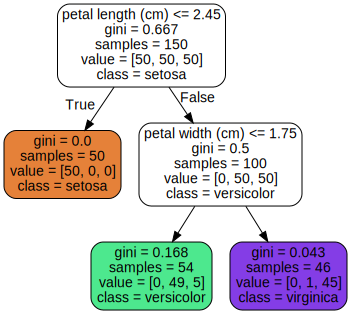

In [6]:
Source.from_file("iris_tree.dot")

## § 6.3.	Estimating Class Probabilities

In [7]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [8]:
tree_clf.predict([[5, 1.5]])

array([1])

## § 6.7.	Regularization Hyperparameters

In [9]:
from sklearn.datasets import make_moons

In [12]:
X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

In [13]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2, random_state=42)

In [14]:
tree_clf1.score(X_moons_test, y_moons_test)

0.901

In [15]:
tree_clf2.score(X_moons_test, y_moons_test)

0.918

## § 6.8.	Regression

In [16]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

In [17]:
np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5 # a single random input feature
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

## § 6.9.	Sensitivity to Axis Orientation

In [18]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [19]:
pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

## § 6.11.	Exercises

7) Train and fine-tune a Decision Tree for the moons dataset by following these steps:
* Use `make_moons(n_samples=10000, noise=0.4)` to generate a moons dataset;
* Use `train_test_split()`to split the dataset into a training set and a test set;
* Use grid search w/ cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`;
* Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. You should get roughly 85% to 87% accuracy.

In [20]:
from sklearn.datasets import make_moons

In [21]:
X_moons, y_moons = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons,
                                                    test_size=0.2,
                                                    random_state=42)

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
params = {
    'max_leaf_nodes': list(range(2, 100)),
    'max_depth': list(range(1, 7)),
    'min_samples_split': [2, 3, 4]
}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42),
                              params,
                              cv=3)

grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]})

In [26]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=17, random_state=42)

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8595

8) Grow a forest by following these steps:
* Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn's `ShuffleSplit` class for this;
* Train one decision tree on each subset, using the best hyperparameter values found in the previous exercise. Evaluate these 1,000 decision trees on the test set. Since they were trained on smaller sets, these decision trees will likely perform worse than the first decision tree, achieving only about 80% accuracy;
* Now comes the magic. For each test set instance, generate the predictions of the 1,000 decision trees, and keep only the most frequent prediction (you can use SciPy's `mode()` function for this. This approach gives you _majority-vote predictions_ over the test set;
* Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a random forest classifier!

In [29]:
from sklearn.model_selection import ShuffleSplit

In [30]:
n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)

for mini_train_index, mini_test_index in rs.split(X_train):
  X_mini_train = X_train[mini_train_index]
  y_mini_train = y_train[mini_train_index]
  mini_sets.append((X_mini_train, y_mini_train))

In [31]:
from sklearn.base import clone

In [32]:
forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
  tree.fit(X_mini_train, y_mini_train)

  y_pred = tree.predict(X_test)
  accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8056605

In [33]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
  Y_pred[tree_index] = tree.predict(X_test)

In [34]:
from scipy.stats import mode

In [35]:
y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

In [36]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.873